In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

/var/folders/7z/lsvtctdd3pz4fhtvppypnv9c0000gp/T/ipykernel_73296/552947930.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
ds2 = pd.read_csv('../dataset2.csv')
ds2.head()

ds2_try2 = ds2.drop(columns=['PATIENT_ID', 'BlindedIDs', 'DC_STUDY_ID', 'MICROARRAY', 'WARNING', 'TESTTYPE'])
ds2_try2.head()

,Stratagene,SITE,IN_DC_STUDY,GENDER,AGE_AT_DIAGNOSIS,RACE,ADJUVANT_CHEMO,ADJUVANT_RT,VITAL_STATUS,FIRST_PROGRESSION_OR_RELAPSE,MONTHS_TO_FIRST_PROGRESSION,MTHS_TO_LAST_CLINICAL_ASSESSMENT,MONTHS_TO_LAST_CONTACT_OR_DEATH,SMOKING_HISTORY,SURGICAL_MARGINS,PATHOLOGIC_N_STAGE,PATHOLOGIC_T_STAGE,MEDIAN_INTENSITY_UNNORMALIZED,PCT_ARRAY_OUTLIER,PCT_SINGLE_OUTLIER,LABORATORY_BATCH,Histologic grade
0,0,MSKCC,1,Male,64.0,White(01),Yes,No,Dead,Yes,8.0,15,16,Currently smoking,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N1, ACCORDING TO AJCC CRITERIA","T3, ACCORDING TO AJCC CRITERIA",191.0,2.536,0.143,NaN,POORLY DIFFERENTIATED
1,0,MSKCC,1,Male,62.0,White(01),Yes,Yes,Alive,Yes,3.0,72,72,Smoked in the past,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N0, ACCORDING TO AJCC CRITERIA","T2, ACCORDING TO AJCC CRITERIA",193.0,4.573,0.288,NaN,Moderate Differentiation
2,0,MSKCC,1,Female,70.0,White(01),No,No,Alive,No,NaN,47,47,Smoked in the past,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N0, ACCORDING TO AJCC CRITERIA","T1, ACCORDING TO AJCC CRITERIA",192.0,1.512,0.131,NaN,Moderate Differentiation
3,0,MSKCC,1,Male,67.0,White(01),No,Yes,Dead,Yes,50.0,52,52,Smoked in the past,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N2, ACCORDING TO AJCC CRITERIA","T3, ACCORDING TO AJCC CRITERIA",192.0,1.252,0.074,NaN,POORLY DIFFERENTIATED
4,0,MSKCC,1,Female,56.0,White(01),Yes,No,Dead,Yes,14.0,28,39,Currently smoking,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N1, ACCORDING TO AJCC CRITERIA","T2, ACCORDING TO AJCC CRITERIA",193.0,1.894,0.142,NaN,POORLY DIFFERENTIATED


In [3]:
filtered_columns = []
for column in ds2_try2.columns:
	unique_values = ds2_try2[column].unique()
	if len(unique_values) == 2 and 0 in unique_values and 1 in unique_values:
		filtered_columns.append(column)

ds2_try2[filtered_columns] = ds2_try2[filtered_columns].astype(bool)
booleans_df_try2 = ds2_try2[filtered_columns].copy()
booleans_df_try2.head()

,Stratagene,IN_DC_STUDY
0,False,True
1,False,True
2,False,True
3,False,True
4,False,True


In [4]:
df_filter_booleans = ds2_try2.drop(columns=booleans_df_try2.columns)

categorical_df_try2 = df_filter_booleans.select_dtypes(include='object')
numerical_df_try2 = df_filter_booleans.select_dtypes(exclude='object')

In [5]:
numeric_columns = numerical_df_try2.columns.to_list()

numeric_categoric_candidates = pd.DataFrame({
    'Minimum': ds2_try2[numeric_columns].min(numeric_only=True),
    'Maximum': ds2_try2[numeric_columns].max(numeric_only=True),
    'Count Unique': ds2_try2[numeric_columns].nunique(),
    'Is All Ints': ds2_try2[numeric_columns].apply(lambda x: x.dropna().apply(float.is_integer).all())
}).sort_values(by=['Is All Ints', 'Count Unique'], ascending=[False, True])

numeric_categoric_candidates

,Minimum,Maximum,Count Unique,Is All Ints
MEDIAN_INTENSITY_UNNORMALIZED,190.000,194.000,5,True
LABORATORY_BATCH,1.000,26.000,26,True
AGE_AT_DIAGNOSIS,33.000,87.000,50,True
MONTHS_TO_FIRST_PROGRESSION,0.460,102.000,112,False
PCT_SINGLE_OUTLIER,0.052,1.787,320,False
PCT_ARRAY_OUTLIER,0.494,21.649,378,False


In [6]:
yes_no_columns = []
for column in categorical_df_try2.columns:
    unique_values = categorical_df_try2[column].unique()
    if len(unique_values) == 2 and "Yes" in unique_values or "No" in unique_values:
        yes_no_columns.append(column)

# Using the yes_no_columns list replace the values in the ds2_try2 Yes to 1 and the values No to 0.
# Join the yes_no_columns dataframe to the booleans_df_try2 dataframe, only if i haven't done it yet.
# And then turn the ds2_try2 dtypes of these columns to be bool

for column in yes_no_columns:
	ds2_try2[column] = ds2_try2[column].replace({"Yes": 1, "No": 0})
	if column not in booleans_df_try2.columns:
		booleans_df_try2[column] = ds2_try2[column]

ds2_try2[yes_no_columns].isnull().sum().to_frame("Missing Values")

,Missing Values
ADJUVANT_CHEMO,27
ADJUVANT_RT,27
FIRST_PROGRESSION_OR_RELAPSE,102


In [7]:
ds2_try2[categorical_df_try2.columns] = ds2_try2[categorical_df_try2.columns].astype('category')

In [8]:
ds2_try2_numeric = ds2_try2.select_dtypes(include=['float64', 'int64'])
ds2_try2_category = ds2_try2.select_dtypes(include='category')
ds2_try2_bool = ds2_try2.select_dtypes(include=bool)

In [9]:
data_clean = ds2_try2.dropna(subset=['VITAL_STATUS'])

# Preparing the data again
X_clean = data_clean.drop('VITAL_STATUS', axis=1).copy()
y_clean = data_clean['VITAL_STATUS'].copy()

# Identifying categorical and numerical columns
categorical_cols_clean = X_clean.select_dtypes(include=['object', 'category']).columns
numerical_cols_clean = X_clean.select_dtypes(include=['int64', 'float64']).columns

# Creating transformers for numerical and categorical data
numerical_transformer = Pipeline(steps=[ 
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Updating the ColumnTransformer with the clean data
preprocessor_clean = ColumnTransformer(transformers=[ 
	('num', numerical_transformer, numerical_cols_clean),
	('cat', categorical_transformer, categorical_cols_clean)
])

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y_clean)

# Convert categorical columns to string type
X_clean[categorical_cols_clean] = X_clean[categorical_cols_clean].astype(str)

# Split the data into training and testing sets
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_clean, y_encoded, test_size=0.2, random_state=0)

# Apply the preprocessor to the training and testing data
X_train_processed = preprocessor_clean.fit_transform(X_train_encoded)
X_test_processed = preprocessor_clean.transform(X_test_encoded)

# Instantiate the XGBoost classifier
xgb_model_clean = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Fit the model with processed training data
xgb_model_clean.fit(X_train_processed, y_train_encoded)

# Now you can use the model to predict on processed test data
y_pred_encoded = xgb_model_clean.predict(X_test_processed)

rmse_encoded = np.sqrt(mean_squared_error(y_test_encoded, y_pred_encoded))

r2_encoded = r2_score(y_test_encoded, y_pred_encoded)

rmse_encoded, r2_encoded

print("Root Mean Squared Error: %.2f" % rmse_encoded)
print("R^2: %.2f" % r2_encoded)

accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Root Mean Squared Error: 0.48
R^2: 0.08
Accuracy: 77.08%


In [10]:
conf_matrix = confusion_matrix(y_test_encoded, y_pred_encoded)

# plot dataframe of the confusion matrix that tells us how many of the predictions were correct and how many were incorrect
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Dead', 'Actual Alive'], columns=['Predicted Dead', 'Predicted Alive'])
conf_matrix_df

,Predicted Dead,Predicted Alive
Actual Dead,40,12
Actual Alive,10,34


In [11]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

# Assuming y_test and y_pred are defined elsewhere in your code
precision, recall, f1, _ = precision_recall_fscore_support(y_test_encoded, y_pred_encoded, average='macro')
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)

results_df = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1': [f1]
})

results_df

,Accuracy,Precision,Recall,F1
0,0.770833,0.769565,0.770979,0.769935


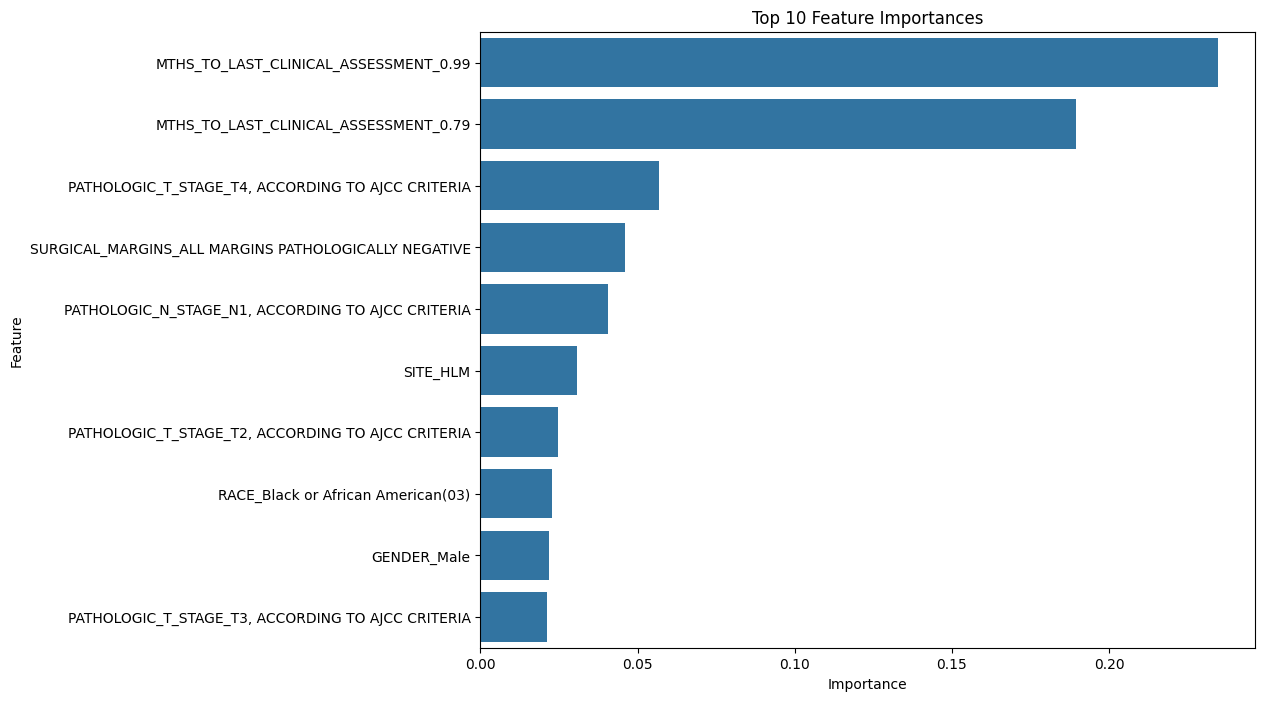

In [12]:
# Extract feature importances from the trained model
feature_importances = xgb_model_clean.feature_importances_

# Check if OneHotEncoder has 'get_feature_names_out', otherwise use 'get_feature_names'
if hasattr(preprocessor_clean.named_transformers_['cat']['onehot'], 'get_feature_names_out'):
	features = preprocessor_clean.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols_clean)
else:
	features = preprocessor_clean.named_transformers_['cat']['onehot'].get_feature_names(categorical_cols_clean)

features = np.r_[features, numerical_cols_clean]

feature_importances_df = pd.DataFrame({
	'Feature': features,
	'Importance': feature_importances
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# divide numerical and categorical features by different colors
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importances_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Feature Importances')
plt.show()

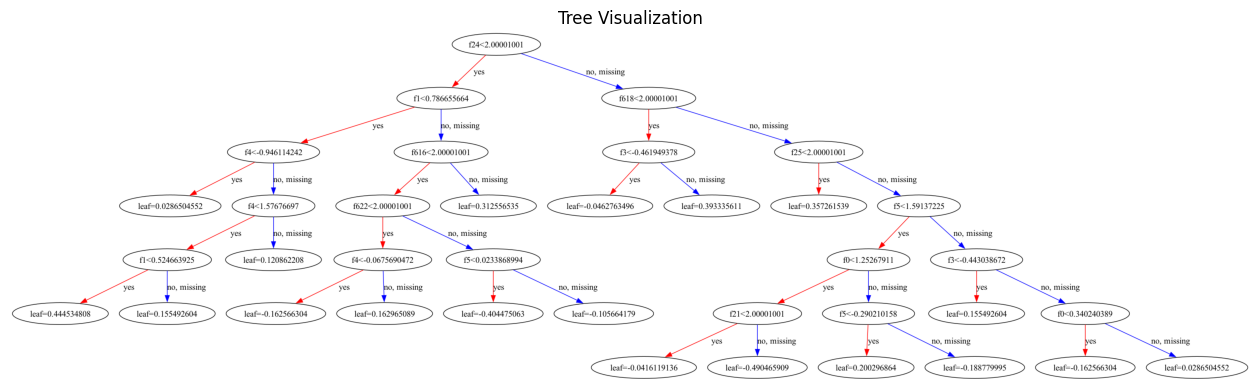

In [13]:
# Plot the first tree with improved quality
xgb.plot_tree(xgb_model_clean, num_trees=0)
plt.title('Tree Visualization')

# Adjust figure size and DPI for higher quality
fig = plt.gcf()
fig.set_size_inches(16, 16)  # You can adjust the size as needed
plt.savefig('Trees Plots/tree_visualization_try3.png', dpi=300)  # Save the plot with higher DPI
plt.show()